In [1]:
import typing as tp
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Tensor:tp.TypeAlias = np.ndarray

In [2]:
def sigmoid(o:Tensor, mode="forward"):
    # inputs: o => (B, 1)
    if mode == "forward":
        return (1/(1+np.exp(-o)))
    elif mode == "backward":
        return np.exp(-o)/(1 + np.exp(-o))**2

def forward_prop(
    x:Tensor, # (B, fi)
    w:Tensor, # (fi, 1)
    b:Tensor, # (1,)
):
    o = x @ w + b # (B, 1)
    return sigmoid(o) # (B, 1)


def backprop(
    x:Tensor, # (B, fi)
    # o:Tensor, # (B, 1)
    y_true:Tensor, # (B, 1)
    y_proba:Tensor, # (B, 1)
):
    """
    dl_dp = (
        # (B, 1)    /(B, 1)        - (B, 1) / (B, 1)
        (1 - y_true)/(1 - y_proba) - (y_true/y_proba)
    )

    dl_do = dl_dp * sigmoid(o, mode="backward") # (B, 1)
    """
    # above simplifies to:
    dl_do = y_proba - y_true # (B, 1)
    
    dl_dw = x.T @ dl_do # (B, fi).T @ (B, 1)
    dl_db = dl_do.sum(0) # (1,)
    return dl_dw, dl_db


def binary_cross_entropy_loss(y_true:Tensor, y_proba:Tensor, epsilon=1e-15):
    y_proba = np.clip(y_proba, epsilon, 1 - epsilon)
    loss = -np.mean(y_true * np.log(y_proba) + (1 - y_true) * np.log(1 - y_proba))
    return loss

In [3]:
def normalize_data(X_train, X_test=None):
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    
    if X_test is not None:
        X_test_normalized = scaler.transform(X_test)
        return X_train_normalized, X_test_normalized, scaler

    return X_train_normalized, scaler

In [4]:
data = load_breast_cancer()
X = data.data
y = data.target[:, None]
print("X.shape, y.shape:", X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_norm, X_test_norm, scaler = normalize_data(X_train, X_test)

print(f"Training set: {X_train_norm.shape[0]} samples")
print(f"Test set: {X_test_norm.shape[0]} samples")

X.shape, y.shape: (569, 30) (569, 1)
Training set: 455 samples
Test set: 114 samples


In [ ]:
# code enhanced for logging and metrics tracking by claude 4
def train_logistic_regression(
    X_train:Tensor, 
    y_train:Tensor, 
    X_test:Tensor=None, 
    y_test:Tensor=None,
    learning_rate:float=0.01, 
    epochs:int=300,
    verbose:bool=True,
    log_interval:int=1
):
    n_features = X_train.shape[1]
    w = np.random.normal(0, 0.01, (n_features, 1))
    b = np.zeros((1,))
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    if verbose:
        print(f"Starting training for {epochs} epochs with learning rate {learning_rate}")
        print(f"Training data shape: {X_train.shape}, labels shape: {y_train.shape}")
        if X_test is not None:
            print(f"Test data shape: {X_test.shape}, labels shape: {y_test.shape}")
        print("-" * 60)
    
    for epoch in range(epochs):
        y_proba_train = forward_prop(X_train, w, b)
        
        train_loss = binary_cross_entropy_loss(y_train, y_proba_train)
        train_losses.append(train_loss)
        
        train_predictions = (y_proba_train > 0.5).astype(int)
        train_accuracy = np.mean(train_predictions == y_train)
        train_accuracies.append(train_accuracy)
        
        dl_dw, dl_db = backprop(X_train, y_train, y_proba_train)
        
        w -= learning_rate * dl_dw
        b -= learning_rate * dl_db
        
        if X_test is not None and y_test is not None:
            y_proba_test = forward_prop(X_test, w, b)
            test_loss = binary_cross_entropy_loss(y_test, y_proba_test)
            test_losses.append(test_loss)
            
            test_predictions = (y_proba_test > 0.5).astype(int)
            test_accuracy = np.mean(test_predictions == y_test)
            test_accuracies.append(test_accuracy)
        
        if verbose and (epoch + 1) % log_interval == 0:
            if X_test is not None:
                print(f"Epoch {epoch+1:4d}/{epochs} | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
                      f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")
            else:
                print(f"Epoch {epoch+1:4d}/{epochs} | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    
    if verbose:
        print("-" * 60)
        print("Training completed!")
        print(f"Final train accuracy: {train_accuracies[-1]:.4f}")
        if test_accuracies:
            print(f"Final test accuracy: {test_accuracies[-1]:.4f}")
    
    return w, b, train_losses, test_losses, train_accuracies, test_accuracies

w, b, train_losses, test_losses, train_accuracies, test_accuracies = train_logistic_regression(
    X_train_norm, y_train, X_test_norm, y_test,
    learning_rate=0.1,
    epochs=290,
    verbose=True,
    log_interval=1
)

Starting training for 290 epochs with learning rate 0.1
Training data shape: (455, 30), labels shape: (455, 1)
Test data shape: (114, 30), labels shape: (114, 1)
------------------------------------------------------------
Epoch    1/290 | Train Loss: 0.6926 | Train Acc: 0.5297 | Test Loss: 1.8014 | Test Acc: 0.9035
Epoch    2/290 | Train Loss: 1.5680 | Train Acc: 0.9385 | Test Loss: 1.0720 | Test Acc: 0.9474
Epoch    3/290 | Train Loss: 1.0355 | Train Acc: 0.9604 | Test Loss: 0.9686 | Test Acc: 0.9386
Epoch    4/290 | Train Loss: 0.5652 | Train Acc: 0.9736 | Test Loss: 0.9219 | Test Acc: 0.9386
Epoch    5/290 | Train Loss: 0.4596 | Train Acc: 0.9780 | Test Loss: 0.8760 | Test Acc: 0.9474
Epoch    6/290 | Train Loss: 0.3988 | Train Acc: 0.9824 | Test Loss: 0.8380 | Test Acc: 0.9474
Epoch    7/290 | Train Loss: 0.3755 | Train Acc: 0.9802 | Test Loss: 0.7919 | Test Acc: 0.9474
Epoch    8/290 | Train Loss: 0.3571 | Train Acc: 0.9802 | Test Loss: 0.7465 | Test Acc: 0.9474
Epoch    9/290 | 

/tmp/ipykernel_12718/137428767.py:4: RuntimeWarning: overflow encountered in exp
  return (1/(1+np.exp(-o)))


In [6]:
# code enhanced by Claude 4
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

# training set performance
train_proba = forward_prop(X_train_norm, w, b)
train_pred = (train_proba > 0.5).astype(int)
train_acc = np.mean(train_pred == y_train)
train_loss = binary_cross_entropy_loss(y_train, train_proba)

# test set performance
test_proba = forward_prop(X_test_norm, w, b)
test_pred = (test_proba > 0.5).astype(int)
test_acc = np.mean(test_pred == y_test)
test_loss = binary_cross_entropy_loss(y_test, test_proba)

print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Training Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

print(f"\nModel Parameters:")
print(f"Weights shape: {w.shape}")
print(f"Bias shape: {b.shape}")
print(f"Weights norm: {np.linalg.norm(w):.4f}")
print(f"Bias value: {b[0]:.4f}")

print(f"\nTraining Progress:")
print(f"Initial train loss: {train_losses[0]:.4f}")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Initial train accuracy: {train_accuracies[0]:.4f}")
print(f"Final train accuracy: {train_accuracies[-1]:.4f}")

if test_losses:
    print(f"Initial test loss: {test_losses[0]:.4f}")
    print(f"Final test loss: {test_losses[-1]:.4f}")
    print(f"Initial test accuracy: {test_accuracies[0]:.4f}")
    print(f"Final test accuracy: {test_accuracies[-1]:.4f}")


FINAL RESULTS
Training Accuracy: 0.9846 (98.46%)
Training Loss: 0.0369
Test Accuracy: 0.9825 (98.25%)
Test Loss: 0.1389

Model Parameters:
Weights shape: (30, 1)
Bias shape: (1,)
Weights norm: 28.2107
Bias value: -1.9513

Training Progress:
Initial train loss: 0.6926
Final train loss: 0.0361
Initial train accuracy: 0.5297
Final train accuracy: 0.9824
Initial test loss: 1.8014
Final test loss: 0.1389
Initial test accuracy: 0.9035
Final test accuracy: 0.9825


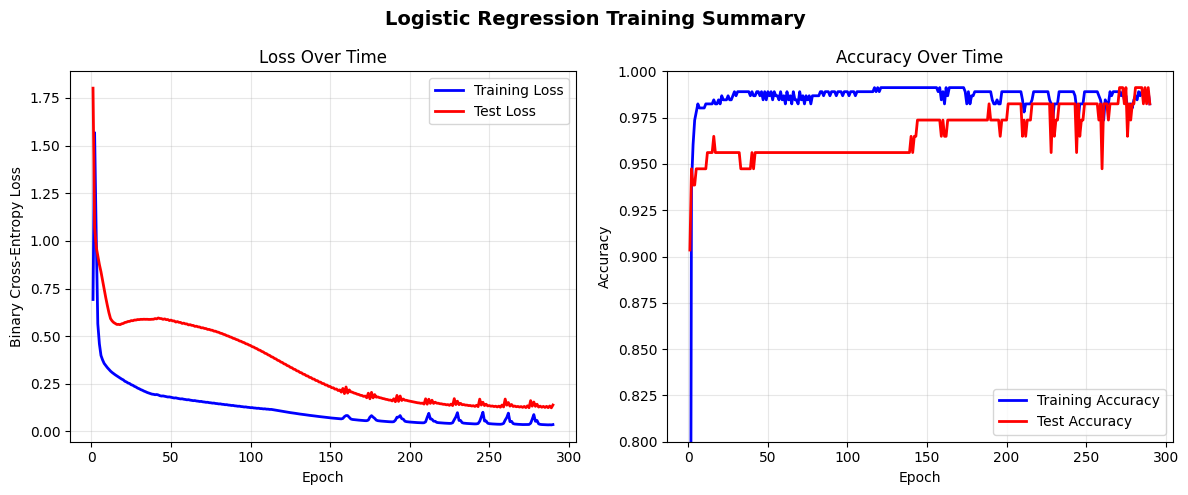

🎯 Model Performance Summary:
   Final Training Accuracy: 98.2%
   Final Test Accuracy: 98.2%
   Epochs to 95% accuracy: 2
   Best test accuracy: 99.1% (epoch 271)


In [7]:
import matplotlib.pyplot as plt
# Simple 2-plot version for cleaner viewing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Logistic Regression Training Summary', fontsize=14, fontweight='bold')

epochs_range = range(1, len(train_losses) + 1)

# Loss plot
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_title('Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Cross-Entropy Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_title('Accuracy Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.8, 1.0])  # Zoom in on the relevant range

plt.tight_layout()
plt.show()

# Summary statistics
print(f"🎯 Model Performance Summary:")
print(f"   Final Training Accuracy: {train_accuracies[-1]:.1%}")
print(f"   Final Test Accuracy: {test_accuracies[-1]:.1%}")
print(f"   Epochs to 95% accuracy: {next((i for i, acc in enumerate(train_accuracies) if acc >= 0.95), 'N/A')}")
print(f"   Best test accuracy: {max(test_accuracies):.1%} (epoch {np.argmax(test_accuracies) + 1})")